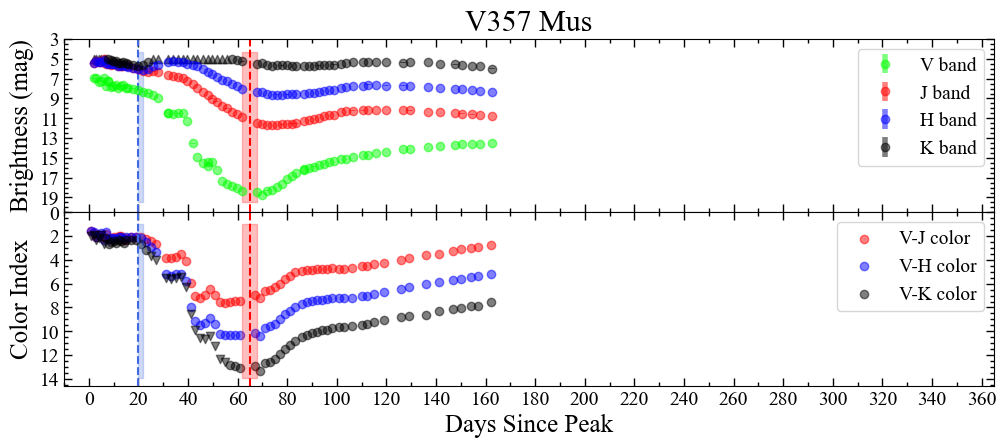

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.axes as pltax
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import math
import os
import pandas as pd
import statistics as stat
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
plt.rcParams.update({"text.usetex":True})
plt.rcdefaults()
font={'family':'Times New Roman',
        # 'weight':'bold',
        'size':18}
mpl.rc('font',**font)
mpl.rc('xtick',labelsize=14) 
mpl.rc('ytick',labelsize=14)
plt.ion()
#block from https://stackoverflow.com/questions/58108964/how-to-open-multiple-files-in-loop-in-python
folderpath=r"C:\Users\oh0si\OneDrive\Documents\Summer_Internship_2021\Photometry_Initial" # make sure to put the 'r' in front
filepaths =[os.path.join(folderpath,name) for name in os.listdir(folderpath)]
files=[]
filenames=[]

for path in filepaths:
    with open(path,'r') as f:
        #name list=filenames
        filename=str(f)
        filename=filename.lstrip("<_io.TextIOWrapper name='C:\\\\Users\\\\oh0si\\\\OneDrive\\\\Documents\\\\Summer_Internship_2021\\\\")
        filename=filename.lstrip("Photometry_Initial")
        filename=filename.lstrip("\\\\")                #strip function was being annoying and sometimes removing letters at the beginning of the filename so I had to split up the strips
        filename=filename.rstrip("' mode='r' encoding='cp1252'>")
        filenames.append(filename)
        #data list=files
        file=np.loadtxt(path,skiprows=4,dtype=str,unpack=True)
        files.append(file)
#block from https://stackoverflow.com/questions/58108964/how-to-open-multiple-files-in-loop-in-python
folderpath=r"C:\Users\oh0si\OneDrive\Documents\Summer_Internship_2021\AAVSO_Photometry_clean" # make sure to put the 'r' in front
filepaths=[os.path.join(folderpath,name) for name in os.listdir(folderpath)]
AAVSOfiles=[]
AAVSOfilenames=[]

for path in filepaths:
    with open(path,'r') as f:
        #name list=filenames
        filename=str(f)
        filename=filename.lstrip("<_io.TextIOWrapper name='C:\\\\Users\\\\oh0si\\\\OneDrive\\\\Documents\\\\Summer_Internship_2021\\\\")
        filename=filename.lstrip("AAVSO_Photometry_clean")
        filename=filename.lstrip("\\\\")                #strip function was being annoying and sometimes removing letters at the beginning of the filename so I had to split up the strips
        filename=filename.rstrip("' mode='r' encoding='cp1252'>")
        AAVSOfilenames.append(filename)
        #data list=files
        file=np.loadtxt(path,dtype=object,delimiter=',',unpack=True)
        AAVSOfiles.append(file)
#-3 is n/a, -2 is bad data, -1 is unsure, 0 is none, 1 is IR excess, 2 is dust dip
Decent_Dust=pd.read_csv("Decent_Lightcurves_Chart_Final.csv")
Decent_Dust_Names=np.array(Decent_Dust["Name"])
Decent_Dust_geq_20=np.array(Decent_Dust["geq_20"])
Decent_Dust_xlim_1=np.array(Decent_Dust["xlim_1"])
Decent_Dust_xlim_2=np.array(Decent_Dust["xlim_2"])
Decent_Dust_decline_start=np.array(Decent_Dust["decline_start"])
Decent_Dust_recover_end=np.array(Decent_Dust["recover_end"])
Decent_Dust_recurrent=np.array(Decent_Dust["Recurrent"])
Decent_Dust_giant=np.array(Decent_Dust["Giant"])
Decent_Dust_category=np.array(Decent_Dust["category"])
Decent_Dust_official=np.array(Decent_Dust["Official"])
# PeakFrame nova ordering is the same as Decent_Dust.
Peak_In_Lit=pd.read_csv("Peak_in_Literature_Final.csv",delimiter=',',skiprows=0,header=0,index_col=0,usecols=np.arange(0,24,1,dtype=int))
Peak_In_Lit.loc[:,'tmax err +':'tmax err -']=np.asarray(Peak_In_Lit.loc[:,'tmax err +':'tmax err -'].fillna(0))
names_arr=np.array(Peak_In_Lit.index)
filenames_arr=np.array(Peak_In_Lit.loc[:,'FileName'])
eruption_dates_arr=np.array(Peak_In_Lit.loc[:,'tmax'])
eruption_date_t0=['N LMC 2009b']
Decent_Dust_official_underscored_l=[]
for obj in Decent_Dust_official:
    Decent_Dust_official_underscored_l.append(obj.replace(' ','_')+'.txt')
Decent_Dust_official_underscored=np.array(Decent_Dust_official_underscored_l,dtype=object)
AAVSOfilenames_indexlist=[]
for i in range(len(AAVSOfilenames)):
    AAVSOfilenames_indexlist.append(np.where(Decent_Dust_official_underscored==AAVSOfilenames[i])[0][0])
AAVSOfilenames_indexarr=np.array(AAVSOfilenames_indexlist)
def Color(xlist1,xlist2,ylist1,ylist2,dimlist1=[],satlist1=[],dimlist2=[],satlist2=[]):
    if len(xlist1)>1 and len(xlist2)>1:
        #Color
        first1=int(xlist1[0])
        last1=int(xlist1[-1])
        first2=int(xlist2[0])
        last2=int(xlist2[-1])
        if first1<first2:  #the first day to check will be the later of the two,as only when both start can there be overlap
            first=first2
        else:
            first=first1
        if last1>last2:    #the last day will be the first of the two,as the con only overlap when both are being measured
            last=last2
        else:
            last=last1
        daylist1=[]                #list of the days for which there are measurements of the K band
        xmeanlist1=[]           #list of the mean dates in the K band bins
        ymeanlist1=[]            #list of the mean mags in the K band bins
        dimlist=[]
        satlist=[]
        tempdimlist1=[]
        tempsatlist1=[]
        x_arr1=np.array(xlist1)   #K band date array to use numpy with
        if(last>0):
            rangemod=1
        elif(last<0):
            rangemod=-1
        else:
            rangemod='0'
        for curr_val in range(first,last+rangemod):  #for dates when both bands might be being measured
            ind_right_side1=np.where(curr_val<=x_arr1)[0] #the right side indices include everything on that day and forward
            ind_left_side1=np.where(curr_val+1>x_arr1)[0] #the left side indices include everything before the next day
            ind_left_end1=ind_right_side1[0] #the left end is the leftmost value on the right side array
            ind_right_end1=ind_left_side1[-1]#[np.size(ind_left_side1)-1] #the right end is the rightmost value on the left side array
            if ind_left_end1<=ind_right_end1: #if the left end coincides with or is to the left of the right end
                ind_full1=np.arange(ind_left_end1,ind_right_end1+1) #list of indices in Kdate that fall within the 1-day range ahead of curr_date
                tempxsumlist1=[] #temporary date list
                tempysumlist1=[] #temporary mag list
                tempdim=False
                tempsat=False
                for ii in ind_full1: #for indices in the list of dates during that day
                    tempxsumlist1.append(xlist1[ii])
                    tempysumlist1.append(ylist1[ii])
                    if ii in dimlist1:
                        tempdim=True
                    if ii in satlist1:
                        tempsat=True
                if tempdim==True:
                    tempdimlist1.append(len(ymeanlist1))
                if tempsat==True:
                    tempsatlist1.append(len(ymeanlist1))
                xmean1=np.mean(np.asarray(tempxsumlist1))
                ymean1=-2.5*np.log10(np.mean(10**(-np.asarray(tempysumlist1)/2.5)))
                daylist1.append(curr_val)
                xmeanlist1.append(xmean1)
                ymeanlist1.append(ymean1)
        daylist2=[]
        xmeanlist2=[]
        ymeanlist2=[]
        tempdimlist2=[]
        tempsatlist2=[]
        x_arr2=np.array(xlist2)
        for curr_val in range(first,last+rangemod):
            ind_right_side2=np.where(curr_val<=x_arr2)[0]
            ind_left_side2=np.where(curr_val+1>x_arr2)[0]
            ind_left_end2=ind_right_side2[0]
            ind_right_end2=ind_left_side2[-1]#[np.size(ind_left_side2)-1]
            if ind_left_end2<=ind_right_end2:
                ind_full2=np.arange(ind_left_end2,ind_right_end2+1) #list of indices in Vdate that fall within the 1-day range ahead of curr_date
                tempxsumlist2=[]
                tempysumlist2=[]
                tempdim=False
                tempsat=False
                for ii in ind_full2:
                    tempxsumlist2.append(xlist2[ii])
                    tempysumlist2.append(ylist2[ii])
                    if (ii in dimlist2):
                        tempdim=True
                    if (ii in satlist2):
                        tempsat=True
                if tempdim==True:
                    tempdimlist2.append(len(ymeanlist2))
                if tempsat==True:
                    tempsatlist2.append(len(ymeanlist2))
                xmean2=np.mean(np.asarray(tempxsumlist2))
                ymean2=-2.5*np.log10(np.mean(10**(-np.asarray(tempysumlist2)/2.5)))
                daylist2.append(curr_val)
                xmeanlist2.append(xmean2)
                ymeanlist2.append(ymean2)
        #find where points exist for both K and V
        daylist=[]
        daylist_arr2=np.array(daylist2)
        for index,day1 in enumerate(daylist1):
            overlap_bool_arr=np.where(daylist_arr2==day1)[0]
            if np.size(overlap_bool_arr)==1:
                if index in tempdimlist1:
                    satlist.append(len(daylist))
                if index in tempsatlist1:
                    dimlist.append(len(daylist))
                if (overlap_bool_arr in tempdimlist2) and (len(daylist) not in dimlist):
                    dimlist.append(len(daylist))
                if (overlap_bool_arr in tempsatlist2) and (len(daylist) not in satlist):
                    satlist.append(len(daylist))
                daylist.append(day1)
        #combine into final color array
        y_list=[]
        daylist_arr1=np.array(daylist1)
        for day in daylist: #for the overlap days (when there is a datapoint during that day for dust dip K and V bands)
            y_list.append(ymeanlist2[int(np.where(daylist_arr2==day)[0][0])]-ymeanlist1[int(np.where(daylist_arr1==day)[0][0])])
    else:
        daylist=[]
        y_list=[]
    return daylist,y_list,np.asarray(dimlist,dtype=int),np.asarray(satlist,dtype=int)
def shortenlist(list1,list2,start,end):
    short_list1=[]
    short_list2=[]
    for i,aa in enumerate(list1):
        if aa>=start and aa<=end:
            short_list1.append(aa)
            short_list2.append(list2[i])
    return short_list1,short_list2
def removebounds(date,mag,err,sat,dim): #returns date and mag (input as a lists) with sat and dim removed, where sat and dim are arrays of indices
    sat=np.asarray(sat,dtype=int)
    dim=np.asarray(dim,dtype=int)
    if len(np.append(sat,dim))>0:
        return list(np.delete(np.asarray(date),np.append(sat,dim))),list(np.delete(np.asarray(mag),np.append(sat,dim))),list(np.delete(np.asarray(err),np.append(sat,dim)))
    else:
        return list(date),list(mag),list(err)
def combinesource(date1,mag1,err1,date2,mag2,err2): #inputs and outputs are lists
    date12unsort=np.array(date1+date2)
    mag12unsort=np.array(mag1+mag2)
    err12unsort=np.array(err1+err2)
    comsort=np.argsort(date12unsort)
    return list(date12unsort[comsort]),list(mag12unsort[comsort]),list(err12unsort[comsort])
def dustchange(date,mag,sta,bot,name):
    date=np.asarray(date)
    mag=np.asarray(mag)
    sta_ind=np.searchsorted(date,sta,'right')-1 #latest measurement BEFORE (or at) start date
    bot_ind=np.argmin(np.abs(date-bot)) #measurement closest to bottom date
    if name in ['V339 Del','V1661 Sco','N LMC 2009b']:
        sta_ind=np.searchsorted(date,sta,'right')
    if name in ['V475 Sct','V5584 Sgr']:
        return 0.0
    else:
        return mag[bot_ind]-mag[sta_ind]
def bool_dimsat_lim(arr,day,dimsat_arr):
    return np.argmin(np.abs(np.asarray(arr)-day)) in dimsat_arr
Decent_Dust_index_list=[]
Kdate_list=[]
Kmag_list=[]
Kerror_list=[]
Vdate_list=[]
Vmag_list=[]
Verror_list=[]
KV_daylist_list=[]
KV_maglist_list=[]
KV_dimlist_list=[]
KV_satlist_list=[]
len_KV_daylist365_list=[]
Vsatlist=[]
Vdimlist=[]
Ksatlist=[]
Kdimlist=[]
Peak_In_Lit_index_list=[]
Kbandname='J band'
Kcolor='r'
Vbandname='V band'
Vcolor='lime'
KVcolor='r'
KVlabel='V-J color'
aavsoVcolor='greenyellow'
aavsoVlabel='AAVSO V band'
aavsoCVcolor='yellowgreen'
aavsoCVlabel='AAVSO CV band'
for file_num in range(int(len(files)/2)):

    #declare files to be indexed
    file1=files[file_num*2]
    filename1=filenames[file_num*2]
    file2=files[file_num*2+1]
    filename2=filenames[file_num*2+1]

    #find tmax
    Peak_In_Lit_index=int(np.where(filenames_arr==filename1)[0][0])
    tmax_JD=eruption_dates_arr[Peak_In_Lit_index]
    tmax=tmax_JD - 2450000.0

    #filter with "Decent_Lightcurves_Chart.csv"
    Decent_Dust_index=int(np.where(Decent_Dust_official==names_arr[Peak_In_Lit_index])[0][0])

    #AAVSO data
    if len(np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0])==1:
        AAVSOfilepresent=True
        AAVSOfile=AAVSOfiles[np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0][0]]
        AAVSOdate,AAVSOmag,AAVSOerr,AAVSOband=AAVSOfile
    else:
        AAVSOfilepresent=False
    AAVSOfilepresent=False
    
    if Decent_Dust_category[Decent_Dust_index]>=-1:
        Peak_In_Lit_index_list.append(Peak_In_Lit_index)
        #first file (ir)
        #variables,convert strings to floats (where applicable)
        date1=np.array(file1[0],dtype=float)
        band1=file1[1]
        mag1=np.array(file1[2],dtype=float)
        err1=np.array(file1[3],dtype=float)
        Kbandfilter=np.bitwise_and(np.where(band1=='J',True,False),np.where(err1<0.5,True,False))
        Kdate=list(date1[Kbandfilter]-tmax)
        Kmag=list(mag1[Kbandfilter])
        Kerror=list(err1[Kbandfilter])
        #second file (opt)
        date2=np.array(file2[0],dtype=float)
        band2=file2[1]
        mag2=np.array(file2[2],dtype=float)
        err2=np.array(file2[3],dtype=float)
        Vbandfilter=np.bitwise_and(np.where(band2=='V',True,False),np.where(err2<0.5,True,False))
        Vdate=list(date2[Vbandfilter]-tmax)
        Vmag=list(mag2[Vbandfilter])
        Verror=list(err2[Vbandfilter])
        if AAVSOfilepresent==True:
            #AAVSO data
            date_nomaskaavso=[]
            aavsoVdate,aavsoCVdate=[],[]
            for no in AAVSOdate:
                date_nomaskaavso.append(float(no))
            mag_nomaskaavso=[]
            aavsoVmag,aavsoCVmag=[],[]
            for no in AAVSOmag:
                no=no.lstrip('<>')
                mag_nomaskaavso.append(float(no))
            error_nomaskaavso=[]
            aavsoVerror,aavsoCVerror=[],[]
            for no in AAVSOerr:
                if len(no)==0:
                    no=0
                error_nomaskaavso.append(float(no))
            #AAVSO mask
            AAVSO_V_arr=np.where(AAVSOband=='V')[0]
            for ii in AAVSO_V_arr:
                aavsoVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoVmag.append(mag_nomaskaavso[ii])
                aavsoVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(Verror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoVdate.pop(ii-i)
                aavsoVmag.pop(ii-i)
                aavsoVerror.pop(ii-i)
            AAVSO_CV_arr=np.where(AAVSOband=='CV')[0]
            for ii in AAVSO_CV_arr:
                aavsoCVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoCVmag.append(mag_nomaskaavso[ii])
                aavsoCVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(aavsoCVerror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoCVdate.pop(ii-i)
                aavsoCVmag.pop(ii-i)
                aavsoCVerror.pop(ii-i)
            aavsoVdate=list(np.array(aavsoVdate)-2450000)
            aavsoCVdate=list(np.array(aavsoCVdate)-2450000)
            Vdate,Vmag,Verror=combinesource(Vdate,Vmag,Verror,aavsoVdate,aavsoVmag,aavsoVerror)
            
        #get lower and upper limit arrays for V and K and confine mags to between 5 and 20.
        Vsat=np.where(np.asarray(Vmag)<=5)[0]
        #Vsatdate=np.asarray(Vdate)[Vsat]
        for i in Vsat:
            Vmag[i]=5
        Vdim=np.where(np.asarray(Vmag)>=20)[0]
        #Vdimdate=np.asarray(Vdate)[Vdim]
        for i in Vdim:
            Vmag[i]=20

        Ksat=np.where(np.asarray(Kmag)<=5)[0]
        #Ksatdate=np.asarray(Kdate)[Ksat]
        for i in Ksat:
            Kmag[i]=5
        Kdim=np.where(np.asarray(Kmag)>=20)[0]
        #Kdimdate=np.asarray(Kdate)[Kdim]
        for i in Kdim:
            Kmag[i]=20
        #colors
        KV_daylist,KV_maglist,KV_dimlist,KV_satlist=Color(Kdate,Vdate,Kmag,Vmag,Kdim,Ksat,Vdim,Vsat)
        if Decent_Dust_official[Decent_Dust_index]=='V339 Del':
            KV_daylist=[]
            KV_maglist=[]
            for no,i in enumerate(Kdate):
                temparr=np.where(np.abs(Vdate-i)<=1)[0]
                if len(temparr)>1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr])/2.5)))-Kmag[no])
                elif len(temparr)==1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr[0]])/2.5)))-Kmag[no])                    
                else:
                    pass
        #shorter color arrays for curve fitting // split at minimum
        KV_decline_start=Decent_Dust_decline_start[Decent_Dust_index]
        KV_recover_end=Decent_Dust_recover_end[Decent_Dust_index]
        startholder=KV_daylist[0]
        KV_daylist365,KV_maglist365=shortenlist(KV_daylist,KV_maglist,startholder,365)
            
        #finding greatest change in v-k color from max in V band
        outlier_ind_list=[]
        for i,mag in enumerate(Vmag):
            if len(np.where((np.abs(np.asarray(Vmag)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        Vmag_nooutliers=np.delete(np.asarray(Vmag),outlier_ind_list)
        Vdate_nooutliers=np.delete(np.asarray(Vdate),outlier_ind_list)
        Vmag_before500=(np.where(Vdate_nooutliers<365)[0])[-1]
        Vmag_before500list=Vmag_nooutliers[:Vmag_before500]
        if len(Vmag_before500list)>0:
            Vmaxdate=Vdate_nooutliers[np.argmin(Vmag_before500list)]
        else:
            Vmaxdate=0
        if Decent_Dust_official[Decent_Dust_index] in ['FM Cir','V612 Sct']:
            Vmaxdate=0
        outlier_ind_list=[]
        for i,mag in enumerate(KV_maglist365):
            if len(np.where((np.abs(np.asarray(KV_maglist365)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        KV_daylist365_nooutliers=np.delete(np.asarray(KV_daylist365),outlier_ind_list)
        KV_maglist365_nooutliers=np.delete(np.asarray(KV_maglist365),outlier_ind_list)
        KVclosest=np.argmin(np.abs(np.asarray(KV_daylist365_nooutliers)-Vmaxdate))
        KVfurthest=np.argmax(np.asarray(KV_maglist365_nooutliers)[KVclosest:])+KVclosest
        day_change_from_max=KV_daylist365_nooutliers[KVfurthest]-KV_daylist365_nooutliers[KVclosest]
        mag_change_from_max=KV_maglist365_nooutliers[KVfurthest]-KV_maglist365_nooutliers[KVclosest]
        #data to change symbol in main plot for saturation at peak/non detection at bottom


        #finding change in v and k band brightness during interval between v-band max and greatest following v-k color change
        Vdatevkchange,Vmagvkchange=shortenlist(Vdate,Vmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        Kdatevkchange,Kmagvkchange=shortenlist(Kdate,Kmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        
        #AAVSO data
        # if 0!=np.size(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0]):
        #     aavsolistind=int(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0])
        #     aavsoDate,aavsoMag,aavsoError,aavsoBand=AAVSOfiles[aavsolistind]
        #main plot
        Decent_Dust_index_list.append(Decent_Dust_index)
        Kdate_list.append(Kdate)
        Kmag_list.append(Kmag)
        Kerror_list.append(Kerror)
        Vdate_list.append(Vdate)
        Vmag_list.append(Vmag)
        Verror_list.append(Verror)
        Vsatlist.append(Vsat)
        Vdimlist.append(Vdim)
        Ksatlist.append(Ksat)
        Kdimlist.append(Kdim)
        if len(KV_daylist365)>=4:
            KV_daylist_list.append(KV_daylist)
            KV_maglist_list.append(KV_maglist)
            KV_dimlist_list.append(KV_dimlist)
            KV_satlist_list.append(KV_satlist)
        else:
            KV_daylist_list.append([])
            KV_maglist_list.append([])
            KV_dimlist_list.append([])
            KV_satlist_list.append([])
        len_KV_daylist365_list.append(int(len(KV_daylist365)))
#code for V-H
for ii in range(len(Decent_Dust_index_list)):
    Decent_Dust_index=Decent_Dust_index_list[ii]
    if Decent_Dust_official[Decent_Dust_index]=="V357 Mus":
        Kdate=Kdate_list[ii]
        Kmag=Kmag_list[ii]
        Kerror=Kerror_list[ii]
        Vdate=Vdate_list[ii]
        Vmag=Vmag_list[ii]
        Verror=Verror_list[ii]
        KV_daylist=KV_daylist_list[ii]
        KV_maglist=KV_maglist_list[ii]
        KV_dimlist=KV_dimlist_list[ii]
        KV_satlist=KV_satlist_list[ii]
        if Decent_Dust_xlim_1[Decent_Dust_index]==-1:
            xlim_1=-10
            xlim_2=365
        else:
            xlim_1=Decent_Dust_xlim_1[Decent_Dust_index]
            xlim_2=Decent_Dust_xlim_2[Decent_Dust_index]
        d_start=float(np.asarray(Decent_Dust.loc[:,'d_start'])[Decent_Dust_index])
        d_bottom=float(np.asarray(Decent_Dust.loc[:,'d_bottom'])[Decent_Dust_index])
        start_patch=np.searchsorted(np.asarray(Vdate),d_start)
        if start_patch==0:
            start_patch='Left'
        else:
            start_patch1=Vdate[start_patch-1]
            start_patch2=Vdate[start_patch]
        bottom_patch=np.searchsorted(np.asarray(Vdate),d_bottom,side='right')
        if bottom_patch==len(Vdate):
            bottom_patch='Right'
        else:
            bottom_patch1=Vdate[bottom_patch-1]
            bottom_patch2=Vdate[bottom_patch]
        fig,(ax1,ax2)=plt.subplots(2,1,sharex=True)
        fig.set_size_inches(12,4.5)
        fig.subplots_adjust(hspace=0)
        boundsVdate,boundsVmag,boundsVerror=removebounds(Vdate,Vmag,Verror,Vsatlist[ii],Vdimlist[ii])
        ax1.errorbar(np.asarray(boundsVdate),boundsVmag,boundsVerror,elinewidth=4,color=Vcolor,label=Vbandname,alpha=0.5,ls='None',marker='o')
        boundsKdate,boundsKmag,boundsKerror=removebounds(Kdate,Kmag,Kerror,Ksatlist[ii],Kdimlist[ii])
        ax1.errorbar(np.asarray(boundsKdate),boundsKmag,boundsKerror,elinewidth=4,color=Kcolor,label=Kbandname,alpha=0.5,ls='None',marker='o')
        if len(Vsatlist[ii])>0:
            ax1.scatter(np.asarray(Vdate)[Vsatlist[ii]],np.full(np.shape(Vsatlist[ii]),5,float),marker="^",color=Vcolor,alpha=0.5,ls='None')
        if len(Vdimlist[ii])>0:
            ax1.scatter(np.asarray(Vdate)[Vdimlist[ii]],np.full(np.shape(Vdimlist[ii]),20,float),marker="v",color=Vcolor,alpha=0.5,ls='None')
        if len(Ksatlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Ksatlist[ii]],np.full(np.shape(Ksatlist[ii]),5,float),marker="^",color=Kcolor,alpha=0.5,ls='None')
        if len(Kdimlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Kdimlist[ii]],np.full(np.shape(Kdimlist[ii]),20,float),marker="v",color=Kcolor,alpha=0.5,ls='None')
        #color (V-K)
        # ax2.scatter(np.asarray(KV_daylist),KV_maglist,color=KVcolor,label=KVlabel,alpha=0.5,lw=0.5)
        boundsVKdate,boundsVKmag,boundsVKerror=removebounds(KV_daylist,KV_maglist,np.zeros(np.shape(KV_daylist)),np.asarray(KV_satlist),np.asarray(KV_dimlist))
        ax2.scatter(np.asarray(boundsVKdate),boundsVKmag,color=KVcolor,label=KVlabel,alpha=0.5,ls='None',marker='o')
        if len(KV_satlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_satlist],np.asarray(KV_maglist)[KV_satlist],marker="^",color=KVcolor,alpha=0.5,ls='None')
        if len(KV_dimlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_dimlist],np.asarray(KV_maglist)[KV_dimlist],marker="v",color=KVcolor,alpha=0.5,ls='None')

Decent_Dust_index_list=[]
Kdate_list=[]
Kmag_list=[]
Kerror_list=[]
Vdate_list=[]
Vmag_list=[]
Verror_list=[]
KV_daylist_list=[]
KV_maglist_list=[]
KV_dimlist_list=[]
KV_satlist_list=[]
len_KV_daylist365_list=[]
Vsatlist=[]
Vdimlist=[]
Ksatlist=[]
Kdimlist=[]
Peak_In_Lit_index_list=[]
Kbandname='H band'
Kcolor='b'
Vbandname='V band'
Vcolor='lime'
KVcolor='b'
KVlabel='V-H color'
aavsoVcolor='greenyellow'
aavsoVlabel='AAVSO V band'
aavsoCVcolor='yellowgreen'
aavsoCVlabel='AAVSO CV band'
for file_num in range(int(len(files)/2)):

    #declare files to be indexed
    file1=files[file_num*2]
    filename1=filenames[file_num*2]
    file2=files[file_num*2+1]
    filename2=filenames[file_num*2+1]

    #find tmax
    Peak_In_Lit_index=int(np.where(filenames_arr==filename1)[0][0])
    tmax_JD=eruption_dates_arr[Peak_In_Lit_index]
    tmax=tmax_JD - 2450000.0

    #filter with "Decent_Lightcurves_Chart.csv"
    Decent_Dust_index=int(np.where(Decent_Dust_official==names_arr[Peak_In_Lit_index])[0][0])

    #AAVSO data
    if len(np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0])==1:
        AAVSOfilepresent=True
        AAVSOfile=AAVSOfiles[np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0][0]]
        AAVSOdate,AAVSOmag,AAVSOerr,AAVSOband=AAVSOfile
    else:
        AAVSOfilepresent=False
    AAVSOfilepresent=False
    
    if Decent_Dust_category[Decent_Dust_index]>=-1:
        Peak_In_Lit_index_list.append(Peak_In_Lit_index)
        #first file (ir)
        #variables,convert strings to floats (where applicable)
        date1=np.array(file1[0],dtype=float)
        band1=file1[1]
        mag1=np.array(file1[2],dtype=float)
        err1=np.array(file1[3],dtype=float)
        Kbandfilter=np.bitwise_and(np.where(band1=='H',True,False),np.where(err1<0.5,True,False))
        Kdate=list(date1[Kbandfilter]-tmax)
        Kmag=list(mag1[Kbandfilter])
        Kerror=list(err1[Kbandfilter])
        #second file (opt)
        date2=np.array(file2[0],dtype=float)
        band2=file2[1]
        mag2=np.array(file2[2],dtype=float)
        err2=np.array(file2[3],dtype=float)
        Vbandfilter=np.bitwise_and(np.where(band2=='V',True,False),np.where(err2<0.5,True,False))
        Vdate=list(date2[Vbandfilter]-tmax)
        Vmag=list(mag2[Vbandfilter])
        Verror=list(err2[Vbandfilter])
        if AAVSOfilepresent==True:
            #AAVSO data
            date_nomaskaavso=[]
            aavsoVdate,aavsoCVdate=[],[]
            for no in AAVSOdate:
                date_nomaskaavso.append(float(no))
            mag_nomaskaavso=[]
            aavsoVmag,aavsoCVmag=[],[]
            for no in AAVSOmag:
                no=no.lstrip('<>')
                mag_nomaskaavso.append(float(no))
            error_nomaskaavso=[]
            aavsoVerror,aavsoCVerror=[],[]
            for no in AAVSOerr:
                if len(no)==0:
                    no=0
                error_nomaskaavso.append(float(no))
            #AAVSO mask
            AAVSO_V_arr=np.where(AAVSOband=='V')[0]
            for ii in AAVSO_V_arr:
                aavsoVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoVmag.append(mag_nomaskaavso[ii])
                aavsoVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(Verror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoVdate.pop(ii-i)
                aavsoVmag.pop(ii-i)
                aavsoVerror.pop(ii-i)
            AAVSO_CV_arr=np.where(AAVSOband=='CV')[0]
            for ii in AAVSO_CV_arr:
                aavsoCVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoCVmag.append(mag_nomaskaavso[ii])
                aavsoCVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(aavsoCVerror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoCVdate.pop(ii-i)
                aavsoCVmag.pop(ii-i)
                aavsoCVerror.pop(ii-i)
            aavsoVdate=list(np.array(aavsoVdate)-2450000)
            aavsoCVdate=list(np.array(aavsoCVdate)-2450000)
            Vdate,Vmag,Verror=combinesource(Vdate,Vmag,Verror,aavsoVdate,aavsoVmag,aavsoVerror)
            
        #get lower and upper limit arrays for V and K and confine mags to between 5 and 20.
        Vsat=np.where(np.asarray(Vmag)<=5)[0]
        #Vsatdate=np.asarray(Vdate)[Vsat]
        for i in Vsat:
            Vmag[i]=5
        Vdim=np.where(np.asarray(Vmag)>=20)[0]
        #Vdimdate=np.asarray(Vdate)[Vdim]
        for i in Vdim:
            Vmag[i]=20

        Ksat=np.where(np.asarray(Kmag)<=5)[0]
        #Ksatdate=np.asarray(Kdate)[Ksat]
        for i in Ksat:
            Kmag[i]=5
        Kdim=np.where(np.asarray(Kmag)>=20)[0]
        #Kdimdate=np.asarray(Kdate)[Kdim]
        for i in Kdim:
            Kmag[i]=20
        #colors
        KV_daylist,KV_maglist,KV_dimlist,KV_satlist=Color(Kdate,Vdate,Kmag,Vmag,Kdim,Ksat,Vdim,Vsat)
        if Decent_Dust_official[Decent_Dust_index]=='V339 Del':
            KV_daylist=[]
            KV_maglist=[]
            for no,i in enumerate(Kdate):
                temparr=np.where(np.abs(Vdate-i)<=1)[0]
                if len(temparr)>1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr])/2.5)))-Kmag[no])
                elif len(temparr)==1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr[0]])/2.5)))-Kmag[no])                    
                else:
                    pass
        #shorter color arrays for curve fitting // split at minimum
        KV_decline_start=Decent_Dust_decline_start[Decent_Dust_index]
        KV_recover_end=Decent_Dust_recover_end[Decent_Dust_index]
        startholder=KV_daylist[0]
        KV_daylist365,KV_maglist365=shortenlist(KV_daylist,KV_maglist,startholder,365)
            
        #finding greatest change in v-k color from max in V band
        outlier_ind_list=[]
        for i,mag in enumerate(Vmag):
            if len(np.where((np.abs(np.asarray(Vmag)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        Vmag_nooutliers=np.delete(np.asarray(Vmag),outlier_ind_list)
        Vdate_nooutliers=np.delete(np.asarray(Vdate),outlier_ind_list)
        Vmag_before500=(np.where(Vdate_nooutliers<365)[0])[-1]
        Vmag_before500list=Vmag_nooutliers[:Vmag_before500]
        if len(Vmag_before500list)>0:
            Vmaxdate=Vdate_nooutliers[np.argmin(Vmag_before500list)]
        else:
            Vmaxdate=0
        if Decent_Dust_official[Decent_Dust_index] in ['FM Cir','V612 Sct']:
            Vmaxdate=0
        outlier_ind_list=[]
        for i,mag in enumerate(KV_maglist365):
            if len(np.where((np.abs(np.asarray(KV_maglist365)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        KV_daylist365_nooutliers=np.delete(np.asarray(KV_daylist365),outlier_ind_list)
        KV_maglist365_nooutliers=np.delete(np.asarray(KV_maglist365),outlier_ind_list)
        KVclosest=np.argmin(np.abs(np.asarray(KV_daylist365_nooutliers)-Vmaxdate))
        KVfurthest=np.argmax(np.asarray(KV_maglist365_nooutliers)[KVclosest:])+KVclosest
        day_change_from_max=KV_daylist365_nooutliers[KVfurthest]-KV_daylist365_nooutliers[KVclosest]
        mag_change_from_max=KV_maglist365_nooutliers[KVfurthest]-KV_maglist365_nooutliers[KVclosest]
        #data to change symbol in main plot for saturation at peak/non detection at bottom


        #finding change in v and k band brightness during interval between v-band max and greatest following v-k color change
        Vdatevkchange,Vmagvkchange=shortenlist(Vdate,Vmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        Kdatevkchange,Kmagvkchange=shortenlist(Kdate,Kmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        
        #AAVSO data
        # if 0!=np.size(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0]):
        #     aavsolistind=int(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0])
        #     aavsoDate,aavsoMag,aavsoError,aavsoBand=AAVSOfiles[aavsolistind]
        #main plot
        Decent_Dust_index_list.append(Decent_Dust_index)
        Kdate_list.append(Kdate)
        Kmag_list.append(Kmag)
        Kerror_list.append(Kerror)
        Vdate_list.append(Vdate)
        Vmag_list.append(Vmag)
        Verror_list.append(Verror)
        Vsatlist.append(Vsat)
        Vdimlist.append(Vdim)
        Ksatlist.append(Ksat)
        Kdimlist.append(Kdim)
        if len(KV_daylist365)>=4:
            KV_daylist_list.append(KV_daylist)
            KV_maglist_list.append(KV_maglist)
            KV_dimlist_list.append(KV_dimlist)
            KV_satlist_list.append(KV_satlist)
        else:
            KV_daylist_list.append([])
            KV_maglist_list.append([])
            KV_dimlist_list.append([])
            KV_satlist_list.append([])
        len_KV_daylist365_list.append(int(len(KV_daylist365)))
#code for V-J
for ii in range(len(Decent_Dust_index_list)):
    Decent_Dust_index=Decent_Dust_index_list[ii]
    if Decent_Dust_official[Decent_Dust_index]=="V357 Mus":
        Kdate=Kdate_list[ii]
        Kmag=Kmag_list[ii]
        Kerror=Kerror_list[ii]
        Vdate=Vdate_list[ii]
        Vmag=Vmag_list[ii]
        Verror=Verror_list[ii]
        KV_daylist=KV_daylist_list[ii]
        KV_maglist=KV_maglist_list[ii]
        KV_dimlist=KV_dimlist_list[ii]
        KV_satlist=KV_satlist_list[ii]
        if Decent_Dust_xlim_1[Decent_Dust_index]==-1:
            xlim_1=-10
            xlim_2=365
        else:
            xlim_1=Decent_Dust_xlim_1[Decent_Dust_index]
            xlim_2=Decent_Dust_xlim_2[Decent_Dust_index]
        d_start=float(np.asarray(Decent_Dust.loc[:,'d_start'])[Decent_Dust_index])
        d_bottom=float(np.asarray(Decent_Dust.loc[:,'d_bottom'])[Decent_Dust_index])
        start_patch=np.searchsorted(np.asarray(Vdate),d_start)
        if start_patch==0:
            start_patch='Left'
        else:
            start_patch1=Vdate[start_patch-1]
            start_patch2=Vdate[start_patch]
        bottom_patch=np.searchsorted(np.asarray(Vdate),d_bottom,side='right')
        if bottom_patch==len(Vdate):
            bottom_patch='Right'
        else:
            bottom_patch1=Vdate[bottom_patch-1]
            bottom_patch2=Vdate[bottom_patch]
        boundsKdate,boundsKmag,boundsKerror=removebounds(Kdate,Kmag,Kerror,Ksatlist[ii],Kdimlist[ii])
        ax1.errorbar(np.asarray(boundsKdate),boundsKmag,boundsKerror,elinewidth=4,color=Kcolor,label=Kbandname,alpha=0.5,ls='None',marker='o')
        boundsVdate,boundsVmag,boundsVerror=removebounds(Vdate,Vmag,Verror,Vsatlist[ii],Vdimlist[ii])
        if len(Ksatlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Ksatlist[ii]],np.full(np.shape(Ksatlist[ii]),5,float),marker="^",color=Kcolor,alpha=0.5,ls='None')
        if len(Kdimlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Kdimlist[ii]],np.full(np.shape(Kdimlist[ii]),20,float),marker="v",color=Kcolor,alpha=0.5,ls='None')
        ax1.set_title(Decent_Dust_official[Decent_Dust_index])
        ax1.set_ylabel('Brightness (mag)')
        ax1.set_xlim(xlim_1,xlim_2)
        ax1.legend(prop={'size':14,
                'weight':'normal'})
        #color (V-K)
        # ax2.scatter(np.asarray(KV_daylist),KV_maglist,color=KVcolor,label=KVlabel,alpha=0.5,lw=0.5)
        boundsVKdate,boundsVKmag,boundsVKerror=removebounds(KV_daylist,KV_maglist,np.zeros(np.shape(KV_daylist)),np.asarray(KV_satlist),np.asarray(KV_dimlist))
        ax2.scatter(np.asarray(boundsVKdate),boundsVKmag,color=KVcolor,label=KVlabel,alpha=0.5,ls='None',marker='o')
        if len(KV_satlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_satlist],np.asarray(KV_maglist)[KV_satlist],marker="^",color=KVcolor,alpha=0.5,ls='None')
        if len(KV_dimlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_dimlist],np.asarray(KV_maglist)[KV_dimlist],marker="v",color=KVcolor,alpha=0.5,ls='None')

Decent_Dust_index_list=[]
Kdate_list=[]
Kmag_list=[]
Kerror_list=[]
Vdate_list=[]
Vmag_list=[]
Verror_list=[]
KV_daylist_list=[]
KV_maglist_list=[]
KV_dimlist_list=[]
KV_satlist_list=[]
len_KV_daylist365_list=[]
Vsatlist=[]
Vdimlist=[]
Ksatlist=[]
Kdimlist=[]
Peak_In_Lit_index_list=[]
Kbandname='K band'
Kcolor='k'
Vbandname='V band'
Vcolor='lime'
KVcolor='k'
KVlabel='V-K color'
aavsoVcolor='greenyellow'
aavsoVlabel='AAVSO V band'
aavsoCVcolor='yellowgreen'
aavsoCVlabel='AAVSO CV band'
for file_num in range(int(len(files)/2)):

    #declare files to be indexed
    file1=files[file_num*2]
    filename1=filenames[file_num*2]
    file2=files[file_num*2+1]
    filename2=filenames[file_num*2+1]

    #find tmax
    Peak_In_Lit_index=int(np.where(filenames_arr==filename1)[0][0])
    tmax_JD=eruption_dates_arr[Peak_In_Lit_index]
    tmax=tmax_JD - 2450000.0

    #filter with "Decent_Lightcurves_Chart.csv"
    Decent_Dust_index=int(np.where(Decent_Dust_official==names_arr[Peak_In_Lit_index])[0][0])

    #AAVSO data
    if len(np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0])==1:
        AAVSOfilepresent=True
        AAVSOfile=AAVSOfiles[np.where(AAVSOfilenames_indexarr==Decent_Dust_index)[0][0]]
        AAVSOdate,AAVSOmag,AAVSOerr,AAVSOband=AAVSOfile
    else:
        AAVSOfilepresent=False
    AAVSOfilepresent=False
    
    if Decent_Dust_category[Decent_Dust_index]>=-1:
        Peak_In_Lit_index_list.append(Peak_In_Lit_index)
        #first file (ir)
        #variables,convert strings to floats (where applicable)
        date1=np.array(file1[0],dtype=float)
        band1=file1[1]
        mag1=np.array(file1[2],dtype=float)
        err1=np.array(file1[3],dtype=float)
        Kbandfilter=np.bitwise_and(np.where(band1=='K',True,False),np.where(err1<0.5,True,False))
        Kdate=list(date1[Kbandfilter]-tmax)
        Kmag=list(mag1[Kbandfilter])
        Kerror=list(err1[Kbandfilter])
        #second file (opt)
        date2=np.array(file2[0],dtype=float)
        band2=file2[1]
        mag2=np.array(file2[2],dtype=float)
        err2=np.array(file2[3],dtype=float)
        Vbandfilter=np.bitwise_and(np.where(band2=='V',True,False),np.where(err2<0.5,True,False))
        Vdate=list(date2[Vbandfilter]-tmax)
        Vmag=list(mag2[Vbandfilter])
        Verror=list(err2[Vbandfilter])
        if AAVSOfilepresent==True:
            #AAVSO data
            date_nomaskaavso=[]
            aavsoVdate,aavsoCVdate=[],[]
            for no in AAVSOdate:
                date_nomaskaavso.append(float(no))
            mag_nomaskaavso=[]
            aavsoVmag,aavsoCVmag=[],[]
            for no in AAVSOmag:
                no=no.lstrip('<>')
                mag_nomaskaavso.append(float(no))
            error_nomaskaavso=[]
            aavsoVerror,aavsoCVerror=[],[]
            for no in AAVSOerr:
                if len(no)==0:
                    no=0
                error_nomaskaavso.append(float(no))
            #AAVSO mask
            AAVSO_V_arr=np.where(AAVSOband=='V')[0]
            for ii in AAVSO_V_arr:
                aavsoVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoVmag.append(mag_nomaskaavso[ii])
                aavsoVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(Verror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoVdate.pop(ii-i)
                aavsoVmag.pop(ii-i)
                aavsoVerror.pop(ii-i)
            AAVSO_CV_arr=np.where(AAVSOband=='CV')[0]
            for ii in AAVSO_CV_arr:
                aavsoCVdate.append(date_nomaskaavso[ii] - tmax)
                aavsoCVmag.append(mag_nomaskaavso[ii])
                aavsoCVerror.append(error_nomaskaavso[ii])
            poplist=np.where(np.asarray(aavsoCVerror)>=0.5)[0]
            for i,ii in enumerate(poplist):
                aavsoCVdate.pop(ii-i)
                aavsoCVmag.pop(ii-i)
                aavsoCVerror.pop(ii-i)
            aavsoVdate=list(np.array(aavsoVdate)-2450000)
            aavsoCVdate=list(np.array(aavsoCVdate)-2450000)
            Vdate,Vmag,Verror=combinesource(Vdate,Vmag,Verror,aavsoVdate,aavsoVmag,aavsoVerror)
            
        #get lower and upper limit arrays for V and K and confine mags to between 5 and 20.
        Vsat=np.where(np.asarray(Vmag)<=5)[0]
        #Vsatdate=np.asarray(Vdate)[Vsat]
        for i in Vsat:
            Vmag[i]=5
        Vdim=np.where(np.asarray(Vmag)>=20)[0]
        #Vdimdate=np.asarray(Vdate)[Vdim]
        for i in Vdim:
            Vmag[i]=20

        Ksat=np.where(np.asarray(Kmag)<=5)[0]
        #Ksatdate=np.asarray(Kdate)[Ksat]
        for i in Ksat:
            Kmag[i]=5
        Kdim=np.where(np.asarray(Kmag)>=20)[0]
        #Kdimdate=np.asarray(Kdate)[Kdim]
        for i in Kdim:
            Kmag[i]=20
        #colors
        KV_daylist,KV_maglist,KV_dimlist,KV_satlist=Color(Kdate,Vdate,Kmag,Vmag,Kdim,Ksat,Vdim,Vsat)
        if Decent_Dust_official[Decent_Dust_index]=='V339 Del':
            KV_daylist=[]
            KV_maglist=[]
            for no,i in enumerate(Kdate):
                temparr=np.where(np.abs(Vdate-i)<=1)[0]
                if len(temparr)>1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr])/2.5)))-Kmag[no])
                elif len(temparr)==1:
                    KV_daylist.append(i)
                    KV_maglist.append(-2.5*np.log10(np.mean(10**(-np.asarray(np.asarray(Vmag)[temparr[0]])/2.5)))-Kmag[no])                    
                else:
                    pass
        #shorter color arrays for curve fitting // split at minimum
        KV_decline_start=Decent_Dust_decline_start[Decent_Dust_index]
        KV_recover_end=Decent_Dust_recover_end[Decent_Dust_index]
        startholder=KV_daylist[0]
        KV_daylist365,KV_maglist365=shortenlist(KV_daylist,KV_maglist,startholder,365)
            
        #finding greatest change in v-k color from max in V band
        outlier_ind_list=[]
        for i,mag in enumerate(Vmag):
            if len(np.where((np.abs(np.asarray(Vmag)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        Vmag_nooutliers=np.delete(np.asarray(Vmag),outlier_ind_list)
        Vdate_nooutliers=np.delete(np.asarray(Vdate),outlier_ind_list)
        Vmag_before500=(np.where(Vdate_nooutliers<365)[0])[-1]
        Vmag_before500list=Vmag_nooutliers[:Vmag_before500]
        if len(Vmag_before500list)>0:
            Vmaxdate=Vdate_nooutliers[np.argmin(Vmag_before500list)]
        else:
            Vmaxdate=0
        if Decent_Dust_official[Decent_Dust_index] in ['FM Cir','V612 Sct']:
            Vmaxdate=0
        outlier_ind_list=[]
        for i,mag in enumerate(KV_maglist365):
            if len(np.where((np.abs(np.asarray(KV_maglist365)-mag))<1)[0])<1:
                outlier_ind_list.append(i)
        KV_daylist365_nooutliers=np.delete(np.asarray(KV_daylist365),outlier_ind_list)
        KV_maglist365_nooutliers=np.delete(np.asarray(KV_maglist365),outlier_ind_list)
        KVclosest=np.argmin(np.abs(np.asarray(KV_daylist365_nooutliers)-Vmaxdate))
        KVfurthest=np.argmax(np.asarray(KV_maglist365_nooutliers)[KVclosest:])+KVclosest
        day_change_from_max=KV_daylist365_nooutliers[KVfurthest]-KV_daylist365_nooutliers[KVclosest]
        mag_change_from_max=KV_maglist365_nooutliers[KVfurthest]-KV_maglist365_nooutliers[KVclosest]
        #data to change symbol in main plot for saturation at peak/non detection at bottom


        #finding change in v and k band brightness during interval between v-band max and greatest following v-k color change
        Vdatevkchange,Vmagvkchange=shortenlist(Vdate,Vmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        Kdatevkchange,Kmagvkchange=shortenlist(Kdate,Kmag,KV_daylist365_nooutliers[KVclosest],KV_daylist365_nooutliers[KVfurthest])
        
        #AAVSO data
        # if 0!=np.size(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0]):
        #     aavsolistind=int(np.where(AAVSOfilenames==(Decent_Dust_official[Decent_Dust_index].replace(' ','_')+".txt"))[0])
        #     aavsoDate,aavsoMag,aavsoError,aavsoBand=AAVSOfiles[aavsolistind]
        #main plot
        Decent_Dust_index_list.append(Decent_Dust_index)
        Kdate_list.append(Kdate)
        Kmag_list.append(Kmag)
        Kerror_list.append(Kerror)
        Vdate_list.append(Vdate)
        Vmag_list.append(Vmag)
        Verror_list.append(Verror)
        Vsatlist.append(Vsat)
        Vdimlist.append(Vdim)
        Ksatlist.append(Ksat)
        Kdimlist.append(Kdim)
        if len(KV_daylist365)>=4:
            KV_daylist_list.append(KV_daylist)
            KV_maglist_list.append(KV_maglist)
            KV_dimlist_list.append(KV_dimlist)
            KV_satlist_list.append(KV_satlist)
        else:
            KV_daylist_list.append([])
            KV_maglist_list.append([])
            KV_dimlist_list.append([])
            KV_satlist_list.append([])
        len_KV_daylist365_list.append(int(len(KV_daylist365)))
#code for V-K
for ii in range(len(Decent_Dust_index_list)):
    Decent_Dust_index=Decent_Dust_index_list[ii]
    if Decent_Dust_official[Decent_Dust_index]=="V357 Mus":
        Kdate=Kdate_list[ii]
        Kmag=Kmag_list[ii]
        Kerror=Kerror_list[ii]
        Vdate=Vdate_list[ii]
        Vmag=Vmag_list[ii]
        Verror=Verror_list[ii]
        KV_daylist=KV_daylist_list[ii]
        KV_maglist=KV_maglist_list[ii]
        KV_dimlist=KV_dimlist_list[ii]
        KV_satlist=KV_satlist_list[ii]
        if Decent_Dust_xlim_1[Decent_Dust_index]==-1:
            xlim_1=-10
            xlim_2=365
        else:
            xlim_1=Decent_Dust_xlim_1[Decent_Dust_index]
            xlim_2=Decent_Dust_xlim_2[Decent_Dust_index]
        d_start=float(np.asarray(Decent_Dust.loc[:,'d_start'])[Decent_Dust_index])
        d_bottom=float(np.asarray(Decent_Dust.loc[:,'d_bottom'])[Decent_Dust_index])
        start_patch=np.searchsorted(np.asarray(Vdate),d_start)
        if start_patch==0:
            start_patch='Left'
        else:
            start_patch1=Vdate[start_patch-1]
            start_patch2=Vdate[start_patch]
        bottom_patch=np.searchsorted(np.asarray(Vdate),d_bottom,side='right')
        if bottom_patch==len(Vdate):
            bottom_patch='Right'
        else:
            bottom_patch1=Vdate[bottom_patch-1]
            bottom_patch2=Vdate[bottom_patch]
        boundsKdate,boundsKmag,boundsKerror=removebounds(Kdate,Kmag,Kerror,Ksatlist[ii],Kdimlist[ii])
        ax1.errorbar(np.asarray(boundsKdate),boundsKmag,boundsKerror,elinewidth=4,color=Kcolor,label=Kbandname,alpha=0.5,ls='None',marker='o')
        boundsVdate,boundsVmag,boundsVerror=removebounds(Vdate,Vmag,Verror,Vsatlist[ii],Vdimlist[ii])
        if len(Ksatlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Ksatlist[ii]],np.full(np.shape(Ksatlist[ii]),5,float),marker="^",color=Kcolor,alpha=0.5,ls='None')
        if len(Kdimlist[ii])>0:
            ax1.scatter(np.asarray(Kdate)[Kdimlist[ii]],np.full(np.shape(Kdimlist[ii]),20,float),marker="v",color=Kcolor,alpha=0.5,ls='None')
        #color (V-K)
        # ax2.scatter(np.asarray(KV_daylist),KV_maglist,color=KVcolor,label=KVlabel,alpha=0.5,lw=0.5)
        boundsVKdate,boundsVKmag,boundsVKerror=removebounds(KV_daylist,KV_maglist,np.zeros(np.shape(KV_daylist)),np.asarray(KV_satlist),np.asarray(KV_dimlist))
        ax2.scatter(np.asarray(boundsVKdate),boundsVKmag,color=KVcolor,label=KVlabel,alpha=0.5,ls='None',marker='o')
        if len(KV_satlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_satlist],np.asarray(KV_maglist)[KV_satlist],marker="^",color=KVcolor,alpha=0.5,ls='None')
        if len(KV_dimlist)>0:
            ax2.scatter(np.asarray(KV_daylist)[KV_dimlist],np.asarray(KV_maglist)[KV_dimlist],marker="v",color=KVcolor,alpha=0.5,ls='None')
ax1.set_ylabel('Brightness (mag)')
ax1.set_xlim(xlim_1,xlim_2)
ax1.legend(prop={'size':14,
        'weight':'normal'})
ax2.set_ylabel('Color Index')
xlabel0=' Peak'
if Decent_Dust_official[Decent_Dust_index]in eruption_date_t0:
    xlabel0=' Discovery'
ax2.set_xlabel('Days Since'+xlabel0)
ax2.set_xlim(xlim_1,xlim_2)
ax2.legend(prop={'size':14,
        'weight':'normal'})
ylim_1_ax1,ylim_2_ax1=ax1.get_ylim()
ylim_1_ax2,ylim_2_ax2=ax2.get_ylim()
ax1.axvline(d_start,ls='--',color='royalblue')
ax2.axvline(d_start,ls='--',color='royalblue')
ax1.axvline(d_bottom,ls='--',color='red')
ax2.axvline(d_bottom,ls='--',color='red')
if start_patch=='Left':
    ax1.fill_between(np.linspace(xlim_1,Vdate[0],3),ylim_1_ax1,ylim_2_ax1,alpha=0.25,color='royalblue')
    ax2.fill_between(np.linspace(xlim_1,Vdate[0],3),ylim_1_ax2,ylim_2_ax2,alpha=0.25,color='royalblue')
else:
    ax1.fill_between(np.linspace(start_patch1,start_patch2,3),ylim_1_ax1,ylim_2_ax1,alpha=0.25,color='royalblue')
    ax2.fill_between(np.linspace(start_patch1,start_patch2,3),ylim_1_ax2,ylim_2_ax2,alpha=0.25,color='royalblue')
if bottom_patch=='Right':
    ax1.fill_between(np.linspace(Vdate[-1],xlim_2,10),ylim_1_ax1,ylim_2_ax1,alpha=0.25,color='red')
    ax2.fill_between(np.linspace(Vdate[-1],xlim_2,10),ylim_1_ax2,ylim_2_ax2,alpha=0.25,color='red')
else:
    ax1.fill_between(np.linspace(bottom_patch1,bottom_patch2,10),ylim_1_ax1,ylim_2_ax1,alpha=0.25,color='red')
    ax2.fill_between(np.linspace(bottom_patch1,bottom_patch2,10),ylim_1_ax2,ylim_2_ax2,alpha=0.25,color='red')
ax1x1,ax1x2=ax1.get_xlim()
ax1y1,ax1y2=ax1.get_ylim()
ax1.set_xticks(np.arange(0,ax1x2,20))
ax1.set_xticks(np.arange(ax1x1,ax1x2,10),minor=True)
ax1.set_yticks(np.arange(np.floor(ax1y1),np.floor(ax1y2)+1,0.5),minor=True)
ax1.set_yticks(np.arange(np.floor(ax1y1),np.floor(ax1y2)+1,step=1 if ax1y2-ax1y1<10 else 2))
ax1.tick_params(which='major',top=True,bottom=True,left=True,right=True,width=1,length=6,direction='in')
ax1.tick_params(which='minor',top=True,bottom=True,left=True,right=True,width=1,length=3,direction='in')
ax1.invert_yaxis()
ax2x1,ax2x2=ax2.get_xlim()
ax2y1,ax2y2=ax2.get_ylim()
ax2.set_xticks(np.arange(0,ax2x2,20))
ax2.set_xticks(np.arange(ax2x1,ax2x2,10),minor=True)
ax2.set_yticks(np.arange(np.floor(ax2y1),np.floor(ax2y2)+1,0.5),minor=True)
ax2.set_yticks(np.arange(np.floor(ax2y1),np.floor(ax2y2)+1,step=1 if ax2y2-ax2y1<10 else 2))
ax2.tick_params(which='major',top=True,bottom=True,left=True,right=True,width=1,length=6,direction='in')
ax2.tick_params(which='minor',top=True,bottom=True,left=True,right=True,width=1,length=3,direction='in')
ax2.invert_yaxis()

plt.savefig("V357MusJHK.pdf",transparent=True,bbox_inches='tight')